## **A**utomated **L**earning for **I**nsightful **C**omparison and **E**valuation - (ALICE)

This is a demo notebook where I demonstrate the main functionalities of the proposed python framework.

For demonstrational purposes, I will be using a simple and small dataset called California Housing, which includes 8 predictors and 1 target (`MedHouseVal`) - which is a house value. This amount of predictors is small for us but a small dataset helps to run the python framework in a short amount of time, so it is very suitable for demonstration purposes.

Because all of the variables in the dataset are continuous, I simulate a binary categorical column from MedHouseVal which just measures if house value is above average. 

I also generate a fake categorical variable just to demonstrate the framework's functionality to treat $n$ amount of columns obtained from dummy encoding of a categorical variable as one variable in feature selection process.

Further details are given in comments and markdown notes throughout the notebook.

In [7]:
# Import numpy for mathematical operations
import numpy as np
# Import pandas for handling data tables
import pandas as pd
# Import stats from scipy - the key statistical package (an extension of Numpy) for python
from scipy import stats
# This just saves the directory
import os
cur_dir = os.getcwd()

from sklearn.model_selection import train_test_split


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [8]:
df = pd.read_excel('Telco_customer_churn.xlsx')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

## What the customer churn dataset includes:

**CustomerID**: A unique ID that identifies each customer.

**Count**: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.

**Country**: The country of the customer’s primary residence.

**State**: The state of the customer’s primary residence.

**City**: The city of the customer’s primary residence.

**Zip Code**: The zip code of the customer’s primary residence.

**Lat Long**: The combined latitude and longitude of the customer’s primary residence.

**Latitude**: The latitude of the customer’s primary residence.

**Longitude**: The longitude of the customer’s primary residence.

**Gender**: The customer’s gender: Male, Female

**Senior Citizen**: Indicates if the customer is 65 or older: Yes, No

**Partner**: Indicate if the customer has a partner: Yes, No

**Dependents**: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

**Tenure Months**: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

**Phone Service**: Indicates if the customer subscribes to home phone service with the company: Yes, No

**Multiple Lines**: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

**Internet Service**: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

**Online Security**: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

**Online Backup**: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

**Tech Support**: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

**Streaming TV**: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

**Streaming Movies**: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

**Contract**: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

**Paperless Billing**: Indicates if the customer has chosen paperless billing: Yes, No

**Payment Method**: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

**Monthly Charge**: Indicates the customer’s current total monthly charge for all their services from the company.

**Total Charges**: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

**Churn Label**: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

**Churn Value**: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

**Churn Score**: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.

**CLTV**: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

**Churn Reason**: A customer’s specific reason for leaving the company. Directly related to Churn Category.

In [10]:
# First begin replacing white spaces in column names with nothing
df.columns = df.columns.str.replace(' ', '')

I begin with dropping variables we do not need

In [11]:
### axis=1 drops column, inplace=True makes sure the existing dataframe gets re-saved with the modification

initial_dataframe_columns = len(df.columns)

# We do not need Churn Label as it is the same as Churn Value
df.drop('ChurnLabel', axis=1, inplace=True)

# Drop customerId if its unique values == length of dataset
if df['CustomerID'].nunique() == len(df):
    print("Dropping CustomerID as no duplicate values observed:")
    df.drop('CustomerID', axis=1, inplace=True)
else:
    print('There are duplicate customer id values')

# Dropping Cities temporarily
df.drop('City', axis=1, inplace=True)

# Dropping country because every obseration is from U.S.
df.drop('Country', axis=1, inplace=True)

# Dropping state because every observation is from California
df.drop('State', axis=1, inplace=True)

df.drop('ZipCode', axis=1, inplace=True)

# Dropping count as its useless
df.drop('Count', axis=1, inplace=True)

# Drop LatLong as it just inclodes both Latitude and Longitude Together
df.drop('LatLong', axis=1, inplace=True)

# Dropping ChurnReason for obvious reasons
df.drop('ChurnReason', axis=1, inplace=True)

print(f'\nDataframe columns reduced from {initial_dataframe_columns} to {len(df.columns)}.')

Dropping CustomerID as no duplicate values observed:

Dataframe columns reduced from 33 to 24.


We can begin by first identifying categorical variables:

In [12]:
# We can begin by looking for categorial variables in the dataset
cat_col = [feature for feature in df.columns if df[feature].dtype == 'object']

print(f'The following features are categorical:')
print('-'*100)
for feature in cat_col:
    print(feature)
print('-'*100)

The following features are categorical:
----------------------------------------------------------------------------------------------------
Gender
SeniorCitizen
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
TotalCharges
----------------------------------------------------------------------------------------------------


Now we can identify which of the features are binary, and which are multi-class. 

In [13]:
# Any variable that has 2 unique values is obviously a binary feature
binary_features = [feature for feature in df[cat_col] if df[feature].nunique() == 2]
# Anything else falls in multiclass
multiclass_features = [feature for feature in df[cat_col] if feature not in binary_features]

print(f'We have the following binary features:')
for feature in binary_features:
    print(feature)
print('-'*100)
print(f'We have the following multi-class features:')
for feature in multiclass_features:
    print(feature)

We have the following binary features:
Gender
SeniorCitizen
Partner
Dependents
PhoneService
PaperlessBilling
----------------------------------------------------------------------------------------------------
We have the following multi-class features:
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaymentMethod
TotalCharges


We can now look at the unique values of the multi-class categorical features:

In [14]:
df[multiclass_features].nunique()

MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaymentMethod          4
TotalCharges        6531
dtype: int64

As long as there are no missing values, we can just encode everything that has 3 or four as dummies.

For the rest we can either do statistical testing based binning, or WOE, or both (actually both sounds nice.)

In [15]:
if all(df.isna().sum()) == 0:
    print('There are no missing values.')

There are no missing values.


In [16]:
features_to_dummify = [feature for feature in multiclass_features if df[feature].nunique() < 5]
print('We will just generate dummies for the following features:')
for feature in features_to_dummify:
    print(feature)

We will just generate dummies for the following features:
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaymentMethod


In [17]:
for feature in features_to_dummify:
    print(f'{feature} Values:')
    print(df[feature].value_counts(dropna=False))
    print('-'*100)

MultipleLines Values:
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
----------------------------------------------------------------------------------------------------
InternetService Values:
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
----------------------------------------------------------------------------------------------------
OnlineSecurity Values:
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
----------------------------------------------------------------------------------------------------
OnlineBackup Values:
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
----------------------------------------------------------------------------------------------------
DeviceProtection Values:
No                     3095
Yes         

In [18]:
features_to_dummify

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [19]:
# Obtain dummies, drop first
dummies = pd.get_dummies(df[features_to_dummify], drop_first=True)

# Replace white spaces
dummies.columns = dummies.columns.str.replace(' ', '_')

print(dummies.columns)

Index(['MultipleLines_No_phone_service', 'MultipleLines_Yes',
       'InternetService_Fiber_optic', 'InternetService_No',
       'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes',
       'OnlineBackup_No_internet_service', 'OnlineBackup_Yes',
       'DeviceProtection_No_internet_service', 'DeviceProtection_Yes',
       'TechSupport_No_internet_service', 'TechSupport_Yes',
       'StreamingTV_No_internet_service', 'StreamingTV_Yes',
       'StreamingMovies_No_internet_service', 'StreamingMovies_Yes',
       'Contract_One_year', 'Contract_Two_year',
       'PaymentMethod_Credit_card_(automatic)',
       'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check'],
      dtype='object')


In [20]:
# Now add these to dataframe and drop the original ones
# pd.concat will concatenate the two dataframes along the column axis
df = pd.concat([df, dummies], axis=1)
print(f'After concatenation there were {len(df.columns)} columns.')

# Drop the original variables
df.drop(features_to_dummify, axis=1, inplace=True)
print(f'After dropping the original variables there were {len(df.columns)} columns.')
print(f'Operation successful if difference is {len(features_to_dummify)}')


After concatenation there were 45 columns.
After dropping the original variables there were 35 columns.
Operation successful if difference is 10


In [21]:
# Re generate multiclass features
multiclass_features = [feature for feature in multiclass_features if feature not in features_to_dummify]

print(f'Remaining multiclass features:')
print('-'*100)
for feature in multiclass_features:
    print(feature)

Remaining multiclass features:
----------------------------------------------------------------------------------------------------
TotalCharges


In [22]:
df[multiclass_features].dtypes

TotalCharges    object
dtype: object

TotalCharges should be a numericla feature so we shoud inspect and transform it to a float datatype instead

In [23]:
df['TotalCharges']

0        108.15
1        151.65
2         820.5
3       3046.05
4        5036.3
         ...   
7038     1419.4
7039     1990.5
7040     7362.9
7041     346.45
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object

In [24]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Now we check if there are missing values as a result and if yes we can drop those rows.

In [25]:
nan_rows = df[df['TotalCharges'].isna()]
nan_rows

,Latitude,Longitude,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,PaperlessBilling,MonthlyCharges,...,TechSupport_Yes,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_One_year,Contract_Two_year,PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
2234,34.084909,-117.258107,Female,No,Yes,No,0,No,Yes,52.55,...,1,0,1,0,0,0,1,0,0,0
2438,36.869584,-118.189241,Male,No,No,No,0,Yes,No,20.25,...,0,1,0,1,0,0,1,0,0,1
2568,37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,80.85,...,0,0,1,0,1,0,1,0,0,1
2667,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,No,25.75,...,0,1,0,1,0,0,1,0,0,1
2856,40.363446,-123.835041,Female,No,Yes,No,0,No,No,56.05,...,1,0,1,0,0,0,1,1,0,0
4331,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,19.85,...,0,1,0,1,0,0,1,0,0,1
4687,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,No,25.35,...,0,1,0,1,0,0,1,0,0,1
5104,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,20.00,...,0,1,0,1,0,0,1,0,0,1
5719,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,Yes,19.70,...,0,1,0,1,0,1,0,0,0,1
6772,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,No,73.35,...,1,0,1,0,0,0,1,0,0,1


In [26]:
## Drop those rows
df = df.dropna(subset=['TotalCharges'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Latitude                               7032 non-null   float64
 1   Longitude                              7032 non-null   float64
 2   Gender                                 7032 non-null   object 
 3   SeniorCitizen                          7032 non-null   object 
 4   Partner                                7032 non-null   object 
 5   Dependents                             7032 non-null   object 
 6   TenureMonths                           7032 non-null   int64  
 7   PhoneService                           7032 non-null   object 
 8   PaperlessBilling                       7032 non-null   object 
 9   MonthlyCharges                         7032 non-null   float64
 10  TotalCharges                           7032 non-null   float64
 11  Chur

Before we take care of the Cities variables, let us take care of the binary columns that are still saved as objects

In [28]:
df[binary_features]

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
0,Male,No,No,No,Yes,Yes
1,Female,No,No,Yes,Yes,Yes
2,Female,No,No,Yes,Yes,Yes
3,Female,No,Yes,Yes,Yes,Yes
4,Male,No,No,Yes,Yes,Yes
...,...,...,...,...,...,...
7038,Female,No,No,No,Yes,Yes
7039,Male,No,Yes,Yes,Yes,Yes
7040,Female,No,Yes,Yes,Yes,Yes
7041,Female,No,Yes,Yes,No,Yes


In [29]:
# Map everything to 1 and 0
# Set up a dictionary where we map
yes_and_no = {
    'Yes': 1,
    'No': 0
}
df['SeniorCitizen'] = df['SeniorCitizen'].map(yes_and_no)
df['Partner'] = df['Partner'].map(yes_and_no)
df['Dependents'] = df['Dependents'].map(yes_and_no)
df['PhoneService'] = df['PhoneService'].map(yes_and_no)
df['PaperlessBilling'] = df['PaperlessBilling'].map(yes_and_no)

In [30]:
# map males to 1 and females to 0
male_female = {
    'Male': 1,
    'Female': 0
}
df['Gender'] = df['Gender'].map(male_female)

In [31]:
df[binary_features]

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
0,1,0,0,0,1,1
1,0,0,0,1,1,1
2,0,0,0,1,1,1
3,0,0,1,1,1,1
4,1,0,0,1,1,1
...,...,...,...,...,...,...
7038,0,0,0,0,1,1
7039,1,0,1,1,1,1
7040,0,0,1,1,1,1
7041,0,0,1,1,0,1


In [32]:
df.columns

Index(['Latitude', 'Longitude', 'Gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'TenureMonths', 'PhoneService', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'ChurnValue', 'ChurnScore', 'CLTV',
       'MultipleLines_No_phone_service', 'MultipleLines_Yes',
       'InternetService_Fiber_optic', 'InternetService_No',
       'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes',
       'OnlineBackup_No_internet_service', 'OnlineBackup_Yes',
       'DeviceProtection_No_internet_service', 'DeviceProtection_Yes',
       'TechSupport_No_internet_service', 'TechSupport_Yes',
       'StreamingTV_No_internet_service', 'StreamingTV_Yes',
       'StreamingMovies_No_internet_service', 'StreamingMovies_Yes',
       'Contract_One_year', 'Contract_Two_year',
       'PaymentMethod_Credit_card_(automatic)',
       'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check'],
      dtype='object')

ChurnValue can be used as binary classification target and ChurnValue as a regression task.

In [33]:
reg_telco = df.drop('ChurnValue', axis=1)
class_telco = df.drop('ChurnScore', axis=1)

In [34]:
class_telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Latitude                               7032 non-null   float64
 1   Longitude                              7032 non-null   float64
 2   Gender                                 7032 non-null   int64  
 3   SeniorCitizen                          7032 non-null   int64  
 4   Partner                                7032 non-null   int64  
 5   Dependents                             7032 non-null   int64  
 6   TenureMonths                           7032 non-null   int64  
 7   PhoneService                           7032 non-null   int64  
 8   PaperlessBilling                       7032 non-null   int64  
 9   MonthlyCharges                         7032 non-null   float64
 10  TotalCharges                           7032 non-null   float64
 11  Chur

In [35]:
class_telco.describe()

,Latitude,Longitude,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,PaperlessBilling,MonthlyCharges,...,TechSupport_Yes,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_One_year,Contract_Two_year,PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,36.283307,-119.799215,0.504693,0.162400,0.482509,0.230375,32.421786,0.903299,0.592719,64.798208,...,0.290102,0.216155,0.384386,0.216155,0.388367,0.209329,0.239619,0.216297,0.336320,0.228100
std,2.456118,2.157588,0.500014,0.368844,0.499729,0.421103,24.545260,0.295571,0.491363,30.085974,...,0.453842,0.411650,0.486484,0.411650,0.487414,0.406858,0.426881,0.411748,0.472483,0.419637
min,32.555828,-124.301372,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.030915,-121.815412,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.587500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.391777,-119.735410,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.227285,-118.043237,1.000000,0.000000,1.000000,0.000000,55.000000,1.000000,1.000000,89.862500,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,41.962127,-114.192901,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
import matplotlib.pyplot as plt

In [64]:
plt.style.use('seaborn')

In [65]:
churn_counts = class_telco['ChurnValue'].value_counts()

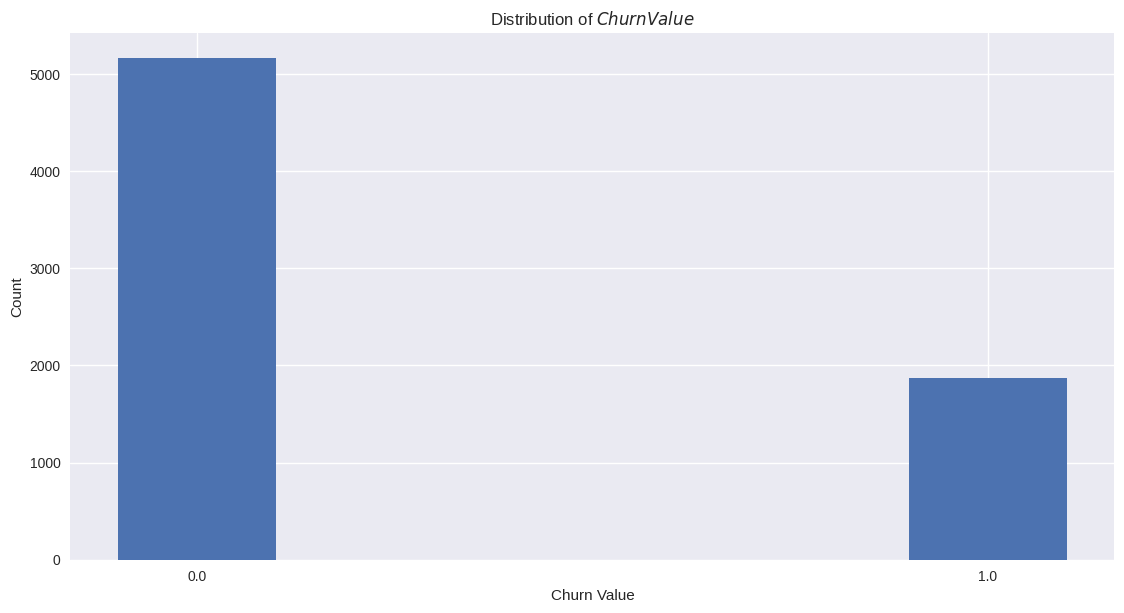

In [77]:

plt.figure(figsize=(12, 6.5))
plt.bar(churn_counts.index, churn_counts.values, width=0.2)
plt.xticks([0, 1], ['0.0', '1.0'])  # Set x-axis ticks to only 0.0 and 1.0
plt.title('Distribution of $ChurnValue$')
plt.xlabel('Churn Value')
plt.ylabel('Count')
plt.savefig('ChurnValueDist.png', dpi=300)
plt.show()


In [57]:
churn_counts.value_counts

<bound method IndexOpsMixin.value_counts of 0    5163
1    1869
Name: ChurnValue, dtype: int64>

<AxesSubplot:>

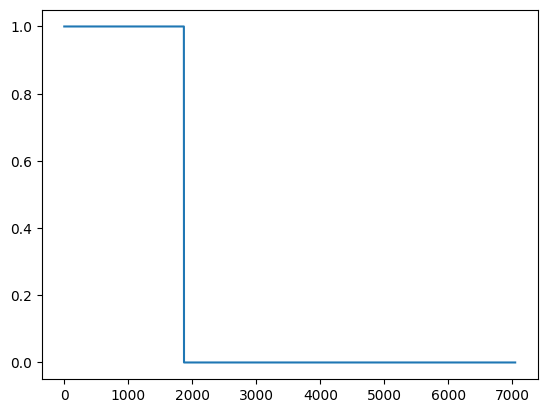

In [37]:
class_telco['ChurnValue'].plot()

### Demonstration of the Framework.

Below I demonstrate the functionalities of the python framework I am working on.

The module is built in a way that allows for either importing the entire thing in one go, or importing some individual functionalities (like functions that compute correlation, or cohen's kappa and so on) separately.

**Entire library:**

In [9]:
# Can just import entire module
import alice

**Individual Functions:**

In [29]:
# Or import individual functions

# Import regression metrics
from alice.metrics.regress import mse, rmse, mae
# Import classification metrics
from alice.metrics.classify import accuracy, precision, recall, f1

# Import regression agreeability metric
from alice.agreeability.regress import pearson
# Import classification agreeability metric
from alice.agreeability.classify import cohen_kappa

# Import regression tests
from alice.testing.regress import t_test
# Import classification tests
from alice.testing.classify import mcnemar_binomial, mcnemar_chisquare

**Algorithm That Combines Backwards Feature Elimination with Inter-Rater Reliability:**

In [30]:
# Import our demo search algorithm 
from alice.search_and_compare.sequential import BackEliminator

Before running the algorithm I just look at all the columns I have:

In [31]:
df.columns

Index(['Latitude', 'Longitude', 'Gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'TenureMonths', 'PhoneService', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'ChurnValue', 'ChurnScore', 'CLTV',
       'MultipleLines_No_phone_service', 'MultipleLines_Yes',
       'InternetService_Fiber_optic', 'InternetService_No',
       'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes',
       'OnlineBackup_No_internet_service', 'OnlineBackup_Yes',
       'DeviceProtection_No_internet_service', 'DeviceProtection_Yes',
       'TechSupport_No_internet_service', 'TechSupport_Yes',
       'StreamingTV_No_internet_service', 'StreamingTV_Yes',
       'StreamingMovies_No_internet_service', 'StreamingMovies_Yes',
       'Contract_One_year', 'Contract_Two_year',
       'PaymentMethod_Credit_card_(automatic)',
       'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check'],
      dtype='object')

In [34]:
# obtain a list of columns we need to fix
d_tofix = [feature for feature in df.columns if df[feature].dtype == 'uint8']

In [36]:
for item in d_tofix:
    print(item)

MultipleLines_No_phone_service
MultipleLines_Yes
InternetService_Fiber_optic
InternetService_No
OnlineSecurity_No_internet_service
OnlineSecurity_Yes
OnlineBackup_No_internet_service
OnlineBackup_Yes
DeviceProtection_No_internet_service
DeviceProtection_Yes
TechSupport_No_internet_service
TechSupport_Yes
StreamingTV_No_internet_service
StreamingTV_Yes
StreamingMovies_No_internet_service
StreamingMovies_Yes
Contract_One_year
Contract_Two_year
PaymentMethod_Credit_card_(automatic)
PaymentMethod_Electronic_check
PaymentMethod_Mailed_check


In [84]:
# Get dummy list for model
dummy_list = [
    ['MultipleLines_No_phone_service', 'MultipleLines_Yes'],
    ['InternetService_Fiber_optic', 'InternetService_No'],
    ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'],
    ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'],
    ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'],
    ['TechSupport_No_internet_service', 'TechSupport_Yes'],
    ['StreamingTV_No_internet_service', 'StreamingTV_Yes'],
    ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'],
    ['Contract_One_year', 'Contract_Two_year'],
    ['PaymentMethod_Credit_card_(automatic)', 'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check']
]
dummy_list

[['MultipleLines_No_phone_service', 'MultipleLines_Yes'],
 ['InternetService_Fiber_optic', 'InternetService_No'],
 ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'],
 ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'],
 ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'],
 ['TechSupport_No_internet_service', 'TechSupport_Yes'],
 ['StreamingTV_No_internet_service', 'StreamingTV_Yes'],
 ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'],
 ['Contract_One_year', 'Contract_Two_year'],
 ['PaymentMethod_Credit_card_(automatic)',
  'PaymentMethod_Electronic_check',
  'PaymentMethod_Mailed_check']]

### Running a regression task

In [15]:
# Import the train-test splitting function from sklearn
from sklearn.model_selection import train_test_split

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MedInc              20640 non-null  float64
 1   HouseAge            20640 non-null  float64
 2   AveRooms            20640 non-null  float64
 3   AveBedrms           20640 non-null  float64
 4   Population          20640 non-null  float64
 5   AveOccup            20640 non-null  float64
 6   Latitude            20640 non-null  float64
 7   Longitude           20640 non-null  float64
 8   MedHouseVal         20640 non-null  float64
 9   HouseEval_nice      20640 non-null  uint8  
 10  HouseEval_not_nice  20640 non-null  uint8  
 11  WallColors_gray     20640 non-null  uint8  
 12  WallColors_white    20640 non-null  uint8  
dtypes: float64(9), uint8(4)
memory usage: 1.5 MB


In [17]:
# Save the target variable as y
y = df['MedHouseVal']
# Save the rest of the predictors as X
X = df.drop('MedHouseVal', axis=1)


In [18]:
# Obtain training and validation sets of 0.8-0.2 proportion. random_state=66 ensures i get same split whenever I re-run the train test split function 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=66)

In [19]:
# Import linear regression from sklearn
from sklearn.linear_model import LinearRegression
# Import decision tree regressor from sklearn
from sklearn.tree import DecisionTreeRegressor

In [20]:
# set up model1
m1 = LinearRegression()
# set up model2
m2 = DecisionTreeRegressor()

In [21]:
# We can look at my documentation for the BackEliminator
BackEliminator?

Init signature:
BackEliminator(
    X=None,
    y=None,
    validation_data=None,
    task_type=None,
    criterion=None,
    agreeability=None,
    dummy_list=None,
    features_to_fix=None,
)
Docstring:     
The class is built for conducting backwards feature elimination in combination with model agreeability. A more detailed documentation will follow.

Args:
    X (pd.DataFrame): A pandas dataframe containing predictors.
    y (pd.DataFrame): A pandas dataframe containing target.
    validation_data (tuple): A tuple of validation data (X_val, y_val).
    task_type (str): String for task type. Available options - 'classification' or 'regression'.
    criterion (str): String for intra-model evaluation criterion. Available options: 'mse', 'rmse', 'mae', 'accuracy', 'precision', 'recall', 'f1'.
    agreeability (str): String for inter-model comparison. Available options: 'pearson', 'cohen_kappa'
    dummy_list (list): List of lists containing column names (str) of dummy features generat

In [22]:
# Initialize the python class.
seeker = BackEliminator(
    X=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    task_type='regression',
    criterion='rmse',
    agreeability='pearson',
    dummy_list=dummy_list,
)

In [23]:
# Run the algorithm by providing model 1 (in this case linreg) and model 2 (decision tree)
results = seeker.compare_all_models(
    m1=m1,
    m2=m2
)

Initial run: fitted both models with full feature set.
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 1 included: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', ['HouseEval_nice', 'HouseEval_not_nice'], ['WallColors_gray', 'WallColors_white']]. RMSE: 0.7314
Model 2 included: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', ['HouseEval_nice', 'HouseEval_not_nice'], ['WallColors_gray', 'WallColors_white']]. RMSE: 0.7327
------------------------------------------------------------------------------------------------------------------------------------------------------
Agreeability Coefficient (pearson): 0.7568
Iteration 1:
------------------------------------------------------------------------------------------------------------------------------------------------------
Results 

We can print the raw dictionary carrying the results:

In [24]:
results

[{'Best: M1 Included Features': ['MedInc',
   'HouseAge',
   'AveRooms',
   'AveBedrms',
   'Population',
   'AveOccup',
   'Latitude',
   'Longitude',
   'HouseEval_nice',
   'HouseEval_not_nice',
   'WallColors_gray',
   'WallColors_white'],
  'Best: M1 rmse': 0.7313631839067938,
  'Best: M2 Included Features': ['MedInc',
   'HouseAge',
   'AveRooms',
   'AveBedrms',
   'Population',
   'AveOccup',
   'Latitude',
   'Longitude',
   'HouseEval_nice',
   'HouseEval_not_nice',
   'WallColors_gray',
   'WallColors_white'],
  'Best: M2 rmse': 0.7327078108794725,
  'Best: Agreeability (pearson)': 0.7567790142007598,
  'All: M1 Mean rmse': 0.7313631839067938,
  'All: M1 STD rmse': 0,
  'All: M2 Mean rmse': 0.7327078108794725,
  'All: M2 STD rmse': 0,
  'All: Mean Agreeability (pearson)': 0.7567790142007598,
  'All: Agreeability St. Dev.': 0},
 {'Best: M1 Included Features': ['MedInc',
   'HouseAge',
   'AveRooms',
   'AveBedrms',
   'Population',
   'Latitude',
   'Longitude',
   'HouseEval

Or we can generate a good looking pandas dataframe from the results from one of my built-in functionalities in the framework.

In [25]:
# For pandas to allow viewing full column width
pd.set_option('display.max_colwidth', None)

In [26]:
# Generate the dataframe
results_df = seeker.dataframe_from_results()

In [27]:
results_df

,Best: M1 Included Features,Best: M1 rmse,Best: M2 Included Features,Best: M2 rmse,Best: Agreeability (pearson),All: M1 Mean rmse,All: M1 STD rmse,All: M2 Mean rmse,All: M2 STD rmse,All: Mean Agreeability (pearson),All: Agreeability St. Dev.
0,"[MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude, HouseEval_nice, HouseEval_not_nice, WallColors_gray, WallColors_white]",0.731363,"[MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude, HouseEval_nice, HouseEval_not_nice, WallColors_gray, WallColors_white]",0.732708,0.756779,0.731363,0.000000,0.732708,0.000000,0.756779,0.000000
1,"[MedInc, HouseAge, AveRooms, AveBedrms, Population, Latitude, Longitude, HouseEval_nice, HouseEval_not_nice, WallColors_gray, WallColors_white]",0.724195,"[MedInc, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude, HouseEval_nice, HouseEval_not_nice, WallColors_gray, WallColors_white]",0.694610,0.768204,0.764343,0.055009,0.741457,0.047692,0.721909,0.069739
2,"[MedInc, HouseAge, AveRooms, AveBedrms, Latitude, Longitude, HouseEval_nice, HouseEval_not_nice, WallColors_gray, WallColors_white]",0.724195,"[MedInc, AveRooms, AveBedrms, Population, Latitude, Longitude, HouseEval_nice, HouseEval_not_nice, WallColors_gray, WallColors_white]",0.673339,0.778682,0.759649,0.054841,0.739133,0.070063,0.727457,0.072945
3,"[MedInc, HouseAge, AveRooms, AveBedrms, Latitude, Longitude, WallColors_gray, WallColors_white]",0.724230,"[MedInc, AveRooms, AveBedrms, Latitude, Longitude, HouseEval_nice, HouseEval_not_nice, WallColors_gray, WallColors_white]",0.656888,0.782832,0.764257,0.056605,0.745178,0.120096,0.724589,0.083219
4,"[MedInc, HouseAge, AveRooms, AveBedrms, Latitude, Longitude]",0.724321,"[AveRooms, AveBedrms, Latitude, Longitude, HouseEval_nice, HouseEval_not_nice, WallColors_gray, WallColors_white]",0.649506,0.741606,0.770011,0.058328,0.740899,0.134446,0.722776,0.085416
5,"[MedInc, HouseAge, AveBedrms, Latitude, Longitude]",0.729908,"[AveRooms, AveBedrms, Latitude, Longitude, WallColors_gray, WallColors_white]",0.642569,0.742414,0.777709,0.059710,0.839496,0.242373,0.631184,0.114599
6,"[MedInc, HouseAge, Latitude, Longitude]",0.734025,"[AveRooms, AveBedrms, Latitude, Longitude]",0.632129,0.743102,0.822217,0.105224,0.868696,0.247616,0.572183,0.169180
7,"[MedInc, Latitude, Longitude]",0.741958,"[AveRooms, Latitude, Longitude]",0.649022,0.719247,0.845597,0.106522,0.922881,0.241907,0.525762,0.163540
8,"[MedInc, Latitude]",0.830187,"[Latitude, Longitude]",0.633092,0.597978,0.897744,0.089312,1.019702,0.277711,0.441698,0.149115
9,[MedInc],0.839073,[Longitude],1.005870,0.326271,1.001300,0.162228,1.025579,0.019710,0.307457,0.018813


In [28]:
# We can now look at the interactive plot
seeker.plot_from_results()

**New functionality:**

I have added a new method to the framework that allows us to compare how statistically different the $n$ amount of best results from each models are from each-other - if we let $n=2$, then we are testing best results from model 1 with second best results from model 1, and testing best results from model 2 with second best results from model 2.

Some experiments on the small dataset we have for demonstrational purposes shows that test statistics (t-test in this regression task, and mcnemar's test for classification task further down in the notebook) already shows that test statistics when comparing predictions of linear / logistic regressors are stable, while test statistics from comparing decision tree models tend do highly with different features.

In [29]:
# You can further inspect my documentation for this functionality
seeker.compare_n_best?

Signature: seeker.compare_n_best(n=None, test=None)
Docstring:
Method for pair-wise comparison of n amount of best predictions obtained by the models.
The pairwise tests are conducted within the predictions of each models and will test if predictions obtained are statistically significantly different from each other.

Args:
    n (int): How many best results to compare.
    test (str): Statistical test to use. Options: 'mcnemar_binomial' and 'mcnemar_chisquare' for binary classification. 't_test' for regression.

Returns:
    None. pval_and_stats_m1 and pval_and_stats_m2 are callable lists containing corresponding test statistics and p-values.

Example: Setting n=3 will test:
        - M1: best predictions against second best predictions; second best predictions and third best predictions.
        - M2: best predictions against second best predictions; second best predictions and third best predictions. 
File:      /tmp/ipykernel_130701/3955809732.py
Type:      method

In [30]:
seeker.compare_n_best(n=9, test='t_test')

Model 1: Results for No. 1 and No. 2 best predictions: P-value: 0.70239521. Test statistic: -0.38210314.
Model 2: Results for No. 1 and No. 2 best predictions: P-value: 0.77188139. Test statistic: -0.28992436.
Model 1: Results for No. 2 and No. 3 best predictions: P-value: 0.70189896. Test statistic: -0.38277231.
Model 2: Results for No. 2 and No. 3 best predictions: P-value: 0.94458274. Test statistic: 0.06951329.
Model 1: Results for No. 3 and No. 4 best predictions: P-value: 0.70389361. Test statistic: -0.38008364.
Model 2: Results for No. 3 and No. 4 best predictions: P-value: 0.48370647. Test statistic: -0.70038528.
Model 1: Results for No. 4 and No. 5 best predictions: P-value: 0.69560290. Test statistic: -0.39127734.
Model 2: Results for No. 4 and No. 5 best predictions: P-value: 0.67762958. Test statistic: -0.41571472.
Model 1: Results for No. 5 and No. 6 best predictions: P-value: 0.73395124. Test statistic: -0.33988637.
Model 2: Results for No. 5 and No. 6 best predictions: P

In [31]:
# The pvalues and test statistics can be saved as variables (list of tuples (p_value, test_statistic))
pval_and_stats_m1 = seeker.pval_and_stats_m1
pval_and_stats_m2 = seeker.pval_and_stats_m2

(A note for self, disregard). How the indexing works in scores_and_preds. The resulting list has three possible indexing.

$\text{score} = \text{list}[i][j][k]$, where $i$ ranges from $0$ to the maximum number of iteration of the search algorithm (however-many features we dropped before ending up with one feature), $j$ ranges from $0$ to $1$ with $0$ grabbing the score and $1$ grabbing the preds, and $k$ ranges from 0 to however-many features could be dropped during the iteration of search algorithm (for example at the very first iteration all $n$ amount of features can be dropped, thus $k$ will have that many things.)

### Check functionality on a classification task

Below I do not include detailed comments at the moment as we just re-run everything but with a different (binary) target

In [38]:
class_telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Latitude                               7032 non-null   float64
 1   Longitude                              7032 non-null   float64
 2   Gender                                 7032 non-null   int64  
 3   SeniorCitizen                          7032 non-null   int64  
 4   Partner                                7032 non-null   int64  
 5   Dependents                             7032 non-null   int64  
 6   TenureMonths                           7032 non-null   int64  
 7   PhoneService                           7032 non-null   int64  
 8   PaperlessBilling                       7032 non-null   int64  
 9   MonthlyCharges                         7032 non-null   float64
 10  TotalCharges                           7032 non-null   float64
 11  Chur

In [43]:
# Use binary target
y = class_telco['ChurnValue']
X = class_telco.drop('ChurnValue', axis=1)


In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=66)

In [51]:
# Standardscaling only the continuous numerical features

float_cols = X_train.select_dtypes(include=['float64']).columns 

standardizer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), float_cols)
    ],
    remainder='passthrough'
)

X_train_scaled = standardizer.fit_transform(X_train)
X_val_scaled = standardizer.transform(X_val)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)


In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [86]:
m1 = LogisticRegression(solver='liblinear')
m2 = RandomForestClassifier(n_estimators=50)

In [87]:
# Save this class under a different name
seeker_2 = BackEliminator(
    X=X_train_scaled,
    y=y_train,
    validation_data=(X_val_scaled, y_val),
    task_type='classification',
    criterion='f1',
    agreeability='cohen_kappa',
    dummy_list=dummy_list
)

In [88]:
results_2 = seeker_2.compare_all_models(
    m1=m1,
    m2=m2
)

Initial run: fitted both models with full feature set.
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 1 included: ['Latitude', 'Longitude', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'TenureMonths', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'CLTV', ['MultipleLines_No_phone_service', 'MultipleLines_Yes'], ['InternetService_Fiber_optic', 'InternetService_No'], ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'], ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'], ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'], ['TechSupport_No_internet_service', 'TechSupport_Yes'], ['StreamingTV_No_internet_service', 'StreamingTV_Yes'], ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'], ['Contract_One_year', 'Contract_Two_year'], ['PaymentMethod_Credit_card_(automatic)', 'PaymentMethod_Electronic_check', 'PaymentMe

In [89]:
results_2

[{'Best: M1 Included Features': ['Latitude',
   'Longitude',
   'Gender',
   'SeniorCitizen',
   'Partner',
   'Dependents',
   'TenureMonths',
   'PhoneService',
   'PaperlessBilling',
   'MonthlyCharges',
   'TotalCharges',
   'CLTV',
   'MultipleLines_No_phone_service',
   'MultipleLines_Yes',
   'InternetService_Fiber_optic',
   'InternetService_No',
   'OnlineSecurity_No_internet_service',
   'OnlineSecurity_Yes',
   'OnlineBackup_No_internet_service',
   'OnlineBackup_Yes',
   'DeviceProtection_No_internet_service',
   'DeviceProtection_Yes',
   'TechSupport_No_internet_service',
   'TechSupport_Yes',
   'StreamingTV_No_internet_service',
   'StreamingTV_Yes',
   'StreamingMovies_No_internet_service',
   'StreamingMovies_Yes',
   'Contract_One_year',
   'Contract_Two_year',
   'PaymentMethod_Credit_card_(automatic)',
   'PaymentMethod_Electronic_check',
   'PaymentMethod_Mailed_check'],
  'Best: M1 f1': 0.6218978102189782,
  'Best: M2 Included Features': ['Latitude',
   'Longitud

In [90]:
results_df_2 = seeker_2.dataframe_from_results()

In [91]:
results_df_2

,Best: M1 Included Features,Best: M1 f1,Best: M2 Included Features,Best: M2 f1,Best: Agreeability (cohen_kappa),All: M1 Mean f1,All: M1 STD f1,All: M2 Mean f1,All: M2 STD f1,All: Mean Agreeability (cohen_kappa),All: Agreeability St. Dev.
0,"[Latitude, Longitude, Gender, SeniorCitizen, P...",0.621898,"[Latitude, Longitude, Gender, SeniorCitizen, P...",0.602985,0.744035,0.621898,0.000000,0.602985,0.000000,0.744035,0.000000
1,"[Latitude, Longitude, Gender, SeniorCitizen, P...",0.624093,"[Longitude, Gender, SeniorCitizen, Partner, De...",0.611940,0.732663,0.617133,0.005075,0.587917,0.012868,0.737530,0.021385
2,"[Latitude, Longitude, Gender, SeniorCitizen, P...",0.627219,"[Longitude, Gender, SeniorCitizen, Partner, De...",0.606876,0.749408,0.617755,0.005567,0.586184,0.011621,0.733439,0.021162
3,"[Latitude, Longitude, Gender, SeniorCitizen, P...",0.640235,"[Longitude, Gender, SeniorCitizen, Partner, De...",0.605970,0.721506,0.618575,0.010398,0.585048,0.013207,0.722530,0.018683
4,"[Latitude, Longitude, Gender, SeniorCitizen, D...",0.638360,"[Longitude, Gender, SeniorCitizen, Partner, De...",0.609467,0.719967,0.618543,0.013117,0.590365,0.013123,0.713135,0.022672
5,"[Latitude, Longitude, Gender, SeniorCitizen, D...",0.636496,"[Longitude, Gender, SeniorCitizen, Partner, De...",0.612426,0.703840,0.615247,0.012382,0.595187,0.012006,0.694527,0.027930
6,"[Latitude, Longitude, Gender, SeniorCitizen, D...",0.636095,"[Longitude, Gender, SeniorCitizen, Partner, De...",0.614925,0.721907,0.621131,0.009561,0.595408,0.009380,0.687875,0.024020
7,"[Latitude, Longitude, Gender, SeniorCitizen, T...",0.639053,"[Longitude, Gender, SeniorCitizen, Partner, De...",0.618401,0.691441,0.617039,0.014353,0.596058,0.010679,0.688652,0.018191
8,"[Latitude, Longitude, Gender, SeniorCitizen, T...",0.632353,"[Longitude, Gender, SeniorCitizen, Partner, De...",0.611028,0.721498,0.611322,0.014221,0.588641,0.011432,0.669186,0.027219
9,"[Latitude, Longitude, Gender, SeniorCitizen, T...",0.633431,"[Longitude, Gender, SeniorCitizen, Partner, De...",0.609865,0.691755,0.617193,0.012501,0.590109,0.010843,0.680366,0.019522


In [92]:
seeker_2.plot_from_results()

In [93]:
seeker_2.compare_n_best(n=5, test='mcnemar_chisquare')

Model 1: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 190.32142857.
Model 2: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 117.77946768.
Model 1: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 227.33061224.
Model 2: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 118.67045455.
Model 1: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 237.10121457.
Model 2: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 129.64015152.
Model 1: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 231.32530120.
Model 2: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 122.29389313.


### Working Code for 3D Plot

```python

# Create a 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=df.index + 1,
        y=df.iloc[:, 4],
        z=df.iloc[:, 1], 
        mode='lines+markers',
        name=f'{df.columns[1]}',
        text=df['Summary_M1'],
        hoverinfo='text'
    ),
    go.Scatter3d(
        x=df.index + 1,
        y=df.iloc[:, 4],
        z=df.iloc[:, 3], 
        mode='lines+markers',
        name=f'{df.columns[3]}',
        text=df['Summary_M2'],
        hoverinfo='text'
    )
])

# Update layout
fig.update_layout(
    title='Agreeability Coefficients and Model Scores Over Algorithm Iterations',
    scene=dict(
        xaxis_title='Iteration',
        yaxis_title='Agreeability',
        zaxis_title='Model Scores'
    ),
    hovermode='closest'
)

# Show the plot
fig.show()

```

### Dependencies

In [30]:
import numpy as np
import pandas as pd
import statsmodels
import sklearn
import scipy
import plotly
import matplotlib
import seaborn as sns
import tensorflow as tf

In [32]:
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'statsmodels: {statsmodels.__version__}')
print(f'sklearn: {sklearn.__version__}')
print(f'scipy: {scipy.__version__}')
print(f'plotly: {plotly.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'tensorflow: {tf.__version__}')


pandas: 1.5.3
numpy: 1.20.3
statsmodels: 0.13.5
sklearn: 1.2.2
scipy: 1.10.0
plotly: 5.18.0
matplotlib: 3.3.4
seaborn: 0.11.1
tensorflow: 2.10.1
